STAT 453: Deep Learning (Spring 2021)  

Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [12]:
#%load_ext watermark
#%watermark -a 'Sebastian Raschka' -v -p torch

- Runs on CPU or GPU (if available)

# L03: Perceptrons

Implementation of the classic Perceptron by Frank Rosenblatt for binary classification (here: 0/1 class labels) in PyTorch

## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Preparing a toy dataset

In [14]:
##########################
### DATASET
##########################

data = np.genfromtxt('ALE_SensorNodeLocalization.txt', delimiter='\t')

X, y = data[:, :2], data[:, 4]
y = np.where(y>0.9, 0, 1)
y = y.astype(np.int)


print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:80]], X[shuffle_idx[80:]]
y_train, y_test = y[shuffle_idx[:80]], y[shuffle_idx[80:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [53 54]
X.shape: (107, 2)
y.shape: (107,)


C:\Users\siu851463587\AppData\Local\Temp\ipykernel_8540\2274029165.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.int)


In [15]:
X_test

array([[ 1.45100379,  0.66138428],
       [ 1.45100379, -0.97166332],
       [-0.78992871, -0.6450538 ],
       [-0.04295121,  0.66138428],
       [-0.78992871,  0.66138428],
       [ 0.25583979,  0.00816524],
       [-0.34174221,  1.64121284],
       [-0.78992871, -0.97166332],
       [-0.78992871,  0.66138428],
       [-0.78992871, -0.97166332],
       [-0.78992871, -0.97166332],
       [ 1.45100379, -0.97166332],
       [-0.78992871,  0.66138428],
       [-0.93932421, -0.31844428],
       [ 1.30160829,  2.29443187],
       [-0.78992871, -0.6450538 ],
       [-0.78992871, -0.97166332],
       [ 1.45100379,  0.66138428],
       [-0.78992871, -0.97166332],
       [ 1.45100379,  0.66138428],
       [-0.34174221,  1.64121284],
       [ 1.45100379, -0.97166332],
       [ 1.45100379, -0.97166332],
       [-0.78992871, -0.97166332],
       [ 1.45100379, -0.97166332],
       [ 1.00281729, -1.95149188],
       [-0.04295121,  0.66138428]])

In [16]:
y_train

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0])

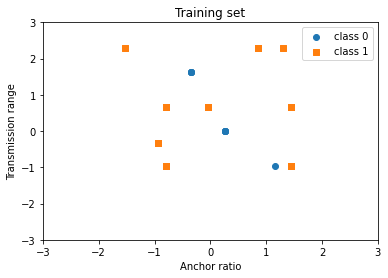

In [17]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('Anchor ratio')
plt.ylabel('Transmission range')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

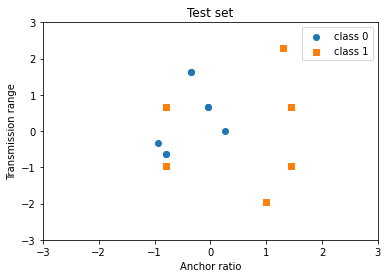

In [18]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('Anchor ratio')
plt.ylabel('Transmission range')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

## Defining the Perceptron model

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
        
        # placeholder vectors so they don't
        # need to be recreated each time
        self.ones = torch.ones(1).to('cpu')  #Ahmed: added to.('cuda') to send tensors used in prediction to GPU device
        self.zeros = torch.zeros(1).to('cpu')

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias      # compute the net input
        print(linear)
        predictions = torch.where(linear > 0., self.ones, self.zeros)       # set threshold
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.shape[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

## Training the Perceptron

In [20]:
ppn = Perceptron(num_features=2)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=100)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

tensor([[0.]])
tensor([[1.5314]])
tensor([[-0.7888]])
tensor([[1.5314]])
tensor([[2.0614]])
tensor([[0.]])
tensor([[0.]])
tensor([[4.0495]])
tensor([[-0.7888]])
tensor([[-0.7888]])
tensor([[0.2950]])
tensor([[4.0495]])
tensor([[0.2950]])
tensor([[-0.0535]])
tensor([[2.8494]])
tensor([[3.9960]])
tensor([[1.8892]])
tensor([[-1.8818]])
tensor([[1.5332]])
tensor([[2.8403]])
tensor([[-0.6195]])
tensor([[-1.8021]])
tensor([[-2.5163]])
tensor([[3.6382]])
tensor([[-0.2503]])
tensor([[-1.7984]])
tensor([[2.1259]])
tensor([[2.1259]])
tensor([[2.9752]])
tensor([[2.0441]])
tensor([[0.5274]])
tensor([[-1.5134]])
tensor([[-1.5134]])
tensor([[-2.7242]])
tensor([[3.2015]])
tensor([[0.0734]])
tensor([[0.1588]])
tensor([[-3.4761]])
tensor([[-0.9213]])
tensor([[-0.9080]])
tensor([[-1.3018]])
tensor([[1.1540]])
tensor([[-0.3486]])
tensor([[3.7010]])
tensor([[-0.7288]])
tensor([[0.8053]])
tensor([[1.3326]])
tensor([[2.6318]])
tensor([[-0.5984]])
tensor([[2.9121]])
tensor([[0.8618]])
tensor([[-1.1374]])
ten

In [21]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

tensor([[-1.3751],
        [-0.2951],
        [-0.6073],
        [-1.4393],
        [-1.4713],
        [-0.9944],
        [-2.1001],
        [-0.3913],
        [-1.4713],
        [-0.3913],
        [-0.3913],
        [-0.2951],
        [-1.4713],
        [-0.8297],
        [-2.4616],
        [-0.6073],
        [-0.3913],
        [-1.3751],
        [-0.3913],
        [-1.3751],
        [-2.1001],
        [-0.2951],
        [-0.2951],
        [-0.3913],
        [-0.2951],
        [ 0.3337],
        [-1.4393]])
Test set accuracy: 70.37%


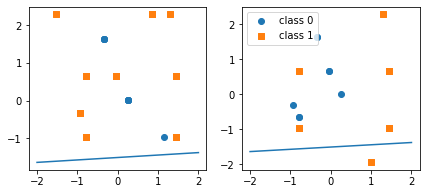

In [22]:
##########################
### 2D Decision Boundary
##########################

w, b = ppn.weights.cpu(), ppn.bias.cpu()  #Ahmed: used .cpu() to send tensors from device to CPU

x0_min = -2
x1_min = ( (-(w[0] * x0_min) - b[0]) 
          / w[1] )

x0_max = 2
x1_max = ( (-(w[0] * x0_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].plot([x0_min, x0_max], [x1_min, x1_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()